# Import Modules & Define Functions

In [23]:
import pandas as pd
import numpy as np
import datetime as dt

In [24]:
def set_data(df, mode='tx'):
    df = df.rename(columns={
        'sequence.number':'sequence_num',
        'payload.time':'payload_time',
        'payload.time_epoch':'payload_time_epoch',
    })
    # df = df.drop(['payload_time','payload_time_epoch'], axis=1)
    df = df[['sequence_num','Timestamp','Timestamp_epoch']]
    if mode == 'tx':
        df = df.rename(columns={
            'Timestamp':'transmit_time',
            'Timestamp_epoch':'transmit_time_epoch',
        })
    if mode == 'rx':
        df = df.rename(columns={
            'Timestamp':'arrival_time',
            'Timestamp_epoch':'arrival_time_epoch',
        })
    return df

def merge_data(df_ultx, df_ulrx, df_dltx, df_dlrx):
    df_ul = pd.merge(df_ultx, df_ulrx, on='sequence_num')  # how='inner'
    df_dl = pd.merge(df_dltx, df_dlrx, on='sequence_num')
    # df_ul = pd.concat([df_ul, pd.DataFrame([(30001,'a'), (30002,'b'), (30003,'c')], columns=['sequence_num','transmit_time'])], ignore_index=True)
    # df_dl = pd.concat([df_dl, pd.DataFrame([(30003,'d'), (30004,'e'), (30005,'f')], columns=['sequence_num','transmit_time'])], ignore_index=True)
    df = pd.merge(df_ul, df_dl, on='sequence_num', suffixes=['_ul','_dl']).sort_values(by='sequence_num').reset_index(drop=True)
    return df

def delete_outliers(df):
    q25, q75 = np.percentile(df['epoch_delta'], 25), np.percentile(df['epoch_delta'], 75)
    iqr = q75 - q25
    lowerb = q25 - iqr * 1.5
    upperb = q75 + iqr * 1.5
    print(lowerb)
    print(upperb)
    display(df.query('epoch_delta < @lowerb | epoch_delta > @upperb'))
    df = df.query('epoch_delta >= @lowerb & epoch_delta <= @upperb').copy().reset_index(drop=True)
    return df

def calc_delta(df):
    df['latency_ul'] = df['arrival_time_epoch_ul'] - df['transmit_time_epoch_ul']
    df['latency_dl'] = df['arrival_time_epoch_dl'] - df['transmit_time_epoch_dl']
    # df['latency_ul'] = (df['arrival_time_ul'] - df['transmit_time_ul']).dt.total_seconds()
    # df['latency_dl'] = (df['arrival_time_dl'] - df['transmit_time_dl']).dt.total_seconds()
    df['epoch_delta'] = round((df['latency_ul'] - df['latency_dl']) / 2, 6)
    df['datetime_delta'] = pd.to_timedelta(df['epoch_delta'], unit='sec')
    return df, df['epoch_delta'].mean().round(6), df['datetime_delta'].mean().round('us')

# Testing

In [25]:
import pandas as pd

In [26]:
df_ultx = pd.read_csv("/home/wmnlab/D/database/2022-11-29/tsync/qc00/udp_uplk_client_pkt_brief.csv", parse_dates=['Timestamp','payload.time'], dtype={'sequence.number':'Int32'})
df_ulrx = pd.read_csv("/home/wmnlab/D/database/2022-11-29/tsync/qc00/udp_uplk_server_pkt_brief.csv", parse_dates=['Timestamp','payload.time'], dtype={'sequence.number':'Int32'})
df_dltx = pd.read_csv("/home/wmnlab/D/database/2022-11-29/tsync/qc00/udp_dnlk_server_pkt_brief.csv", parse_dates=['Timestamp','payload.time'], dtype={'sequence.number':'Int32'})
df_dlrx = pd.read_csv("/home/wmnlab/D/database/2022-11-29/tsync/qc00/udp_dnlk_client_pkt_brief.csv", parse_dates=['Timestamp','payload.time'], dtype={'sequence.number':'Int32'})
df_ultx = set_data(df_ultx, 'tx')
df_ulrx = set_data(df_ulrx, 'rx')
df_dltx = set_data(df_dltx, 'tx')
df_dlrx = set_data(df_dlrx, 'rx')

In [27]:
print('df_ultx')
display(df_ultx)
print('df_ulrx')
display(df_ulrx)
print('df_dltx')
display(df_dltx)
print('df_dlrx')
display(df_dlrx)

df_ultx


,sequence_num,transmit_time,transmit_time_epoch
0,8,2022-11-29 15:51:04.041253,1.669708e+09
1,9,2022-11-29 15:51:04.043246,1.669708e+09
2,10,2022-11-29 15:51:04.045248,1.669708e+09
3,11,2022-11-29 15:51:04.047366,1.669708e+09
4,12,2022-11-29 15:51:04.049354,1.669708e+09
...,...,...,...
29988,29996,2022-11-29 15:52:04.017394,1.669708e+09
29989,29997,2022-11-29 15:52:04.019391,1.669708e+09
29990,29998,2022-11-29 15:52:04.021395,1.669708e+09
29991,29999,2022-11-29 15:52:04.023392,1.669708e+09


df_ulrx


,sequence_num,arrival_time,arrival_time_epoch
0,1,2022-11-29 15:51:04.009877,1.669708e+09
1,2,2022-11-29 15:51:04.011750,1.669708e+09
2,3,2022-11-29 15:51:04.013741,1.669708e+09
3,4,2022-11-29 15:51:04.015774,1.669708e+09
4,5,2022-11-29 15:51:04.017774,1.669708e+09
...,...,...,...
29995,29996,2022-11-29 15:52:03.998794,1.669708e+09
29996,29997,2022-11-29 15:52:04.000758,1.669708e+09
29997,29998,2022-11-29 15:52:04.002793,1.669708e+09
29998,29999,2022-11-29 15:52:04.004762,1.669708e+09


df_dltx


,sequence_num,transmit_time,transmit_time_epoch
0,1,2022-11-29 15:51:04.009144,1.669708e+09
1,2,2022-11-29 15:51:04.011230,1.669708e+09
2,3,2022-11-29 15:51:04.013234,1.669708e+09
3,4,2022-11-29 15:51:04.015207,1.669708e+09
4,5,2022-11-29 15:51:04.017224,1.669708e+09
...,...,...,...
29995,29996,2022-11-29 15:52:03.999235,1.669708e+09
29996,29997,2022-11-29 15:52:04.001237,1.669708e+09
29997,29998,2022-11-29 15:52:04.003235,1.669708e+09
29998,29999,2022-11-29 15:52:04.005233,1.669708e+09


df_dlrx


,sequence_num,arrival_time,arrival_time_epoch
0,8,2022-11-29 15:51:04.041221,1.669708e+09
1,9,2022-11-29 15:51:04.043404,1.669708e+09
2,10,2022-11-29 15:51:04.045405,1.669708e+09
3,11,2022-11-29 15:51:04.047427,1.669708e+09
4,12,2022-11-29 15:51:04.049423,1.669708e+09
...,...,...,...
29988,29996,2022-11-29 15:52:04.018326,1.669708e+09
29989,29997,2022-11-29 15:52:04.020197,1.669708e+09
29990,29998,2022-11-29 15:52:04.022332,1.669708e+09
29991,29999,2022-11-29 15:52:04.024261,1.669708e+09


In [28]:
df = merge_data(df_ultx, df_ulrx, df_dltx, df_dlrx)
df, epoch_delta, datetime_delta = calc_delta(df)
print(epoch_delta)
print(datetime_delta)
display(df)

-0.018294
-1 days +23:59:59.981706


,sequence_num,transmit_time_ul,transmit_time_epoch_ul,arrival_time_ul,arrival_time_epoch_ul,transmit_time_dl,transmit_time_epoch_dl,arrival_time_dl,arrival_time_epoch_dl,latency_ul,latency_dl,epoch_delta,datetime_delta
0,8,2022-11-29 15:51:04.041253,1.669708e+09,2022-11-29 15:51:04.023921,1.669708e+09,2022-11-29 15:51:04.023214,1.669708e+09,2022-11-29 15:51:04.041221,1.669708e+09,-0.017332,0.018007,-0.017669,-1 days +23:59:59.982331
1,9,2022-11-29 15:51:04.043246,1.669708e+09,2022-11-29 15:51:04.025720,1.669708e+09,2022-11-29 15:51:04.025200,1.669708e+09,2022-11-29 15:51:04.043404,1.669708e+09,-0.017526,0.018204,-0.017865,-1 days +23:59:59.982135
2,10,2022-11-29 15:51:04.045248,1.669708e+09,2022-11-29 15:51:04.027716,1.669708e+09,2022-11-29 15:51:04.027196,1.669708e+09,2022-11-29 15:51:04.045405,1.669708e+09,-0.017532,0.018209,-0.017871,-1 days +23:59:59.982129
3,11,2022-11-29 15:51:04.047366,1.669708e+09,2022-11-29 15:51:04.029749,1.669708e+09,2022-11-29 15:51:04.029215,1.669708e+09,2022-11-29 15:51:04.047427,1.669708e+09,-0.017617,0.018212,-0.017914,-1 days +23:59:59.982086
4,12,2022-11-29 15:51:04.049354,1.669708e+09,2022-11-29 15:51:04.031737,1.669708e+09,2022-11-29 15:51:04.031219,1.669708e+09,2022-11-29 15:51:04.049423,1.669708e+09,-0.017617,0.018204,-0.017910,-1 days +23:59:59.982090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29988,29996,2022-11-29 15:52:04.017394,1.669708e+09,2022-11-29 15:52:03.998794,1.669708e+09,2022-11-29 15:52:03.999235,1.669708e+09,2022-11-29 15:52:04.018326,1.669708e+09,-0.018600,0.019091,-0.018846,-1 days +23:59:59.981154
29989,29997,2022-11-29 15:52:04.019391,1.669708e+09,2022-11-29 15:52:04.000758,1.669708e+09,2022-11-29 15:52:04.001237,1.669708e+09,2022-11-29 15:52:04.020197,1.669708e+09,-0.018633,0.018960,-0.018797,-1 days +23:59:59.981203
29990,29998,2022-11-29 15:52:04.021395,1.669708e+09,2022-11-29 15:52:04.002793,1.669708e+09,2022-11-29 15:52:04.003235,1.669708e+09,2022-11-29 15:52:04.022332,1.669708e+09,-0.018602,0.019097,-0.018849,-1 days +23:59:59.981151
29991,29999,2022-11-29 15:52:04.023392,1.669708e+09,2022-11-29 15:52:04.004762,1.669708e+09,2022-11-29 15:52:04.005233,1.669708e+09,2022-11-29 15:52:04.024261,1.669708e+09,-0.018630,0.019028,-0.018829,-1 days +23:59:59.981171


## Compensation

In [29]:
df_test = df.copy()
df_test['transmit_time_ul'] = df_test['transmit_time_ul'] + df_test['datetime_delta']
df_test['arrival_time_dl'] = df_test['arrival_time_dl'] + df_test['datetime_delta']
df_test['transmit_time_epoch_ul'] = df_test['transmit_time_epoch_ul'] + df_test['epoch_delta']
df_test['arrival_time_epoch_dl'] = df_test['arrival_time_epoch_dl'] + df_test['epoch_delta']
df_test['latency_ul'] = df_test['arrival_time_epoch_ul'] - df_test['transmit_time_epoch_ul']
df_test['latency_dl'] = df_test['arrival_time_epoch_dl'] - df_test['transmit_time_epoch_dl']
# df_test['latency_ul'] = (df_test['arrival_time_ul'] - df_test['transmit_time_ul']).dt.total_seconds()
# df_test['latency_dl'] = (df_test['arrival_time_dl'] - df_test['transmit_time_dl']).dt.total_seconds()
print('{:.6f}'.format(df_test['latency_dl'].min().round(6)))
print('{:.6f}'.format(df_test['latency_dl'].max().round(6)))
print('{:.6f}'.format(df_test['latency_ul'].min().round(6)))
print('{:.6f}'.format(df_test['latency_ul'].max().round(6)))
display(df_test)

0.000096
0.001571
0.000095
0.001571


,sequence_num,transmit_time_ul,transmit_time_epoch_ul,arrival_time_ul,arrival_time_epoch_ul,transmit_time_dl,transmit_time_epoch_dl,arrival_time_dl,arrival_time_epoch_dl,latency_ul,latency_dl,epoch_delta,datetime_delta
0,8,2022-11-29 15:51:04.023584,1.669708e+09,2022-11-29 15:51:04.023921,1.669708e+09,2022-11-29 15:51:04.023214,1.669708e+09,2022-11-29 15:51:04.023552,1.669708e+09,0.000337,0.000338,-0.017669,-1 days +23:59:59.982331
1,9,2022-11-29 15:51:04.025381,1.669708e+09,2022-11-29 15:51:04.025720,1.669708e+09,2022-11-29 15:51:04.025200,1.669708e+09,2022-11-29 15:51:04.025539,1.669708e+09,0.000339,0.000339,-0.017865,-1 days +23:59:59.982135
2,10,2022-11-29 15:51:04.027377,1.669708e+09,2022-11-29 15:51:04.027716,1.669708e+09,2022-11-29 15:51:04.027196,1.669708e+09,2022-11-29 15:51:04.027534,1.669708e+09,0.000339,0.000338,-0.017871,-1 days +23:59:59.982129
3,11,2022-11-29 15:51:04.029452,1.669708e+09,2022-11-29 15:51:04.029749,1.669708e+09,2022-11-29 15:51:04.029215,1.669708e+09,2022-11-29 15:51:04.029513,1.669708e+09,0.000297,0.000298,-0.017914,-1 days +23:59:59.982086
4,12,2022-11-29 15:51:04.031444,1.669708e+09,2022-11-29 15:51:04.031737,1.669708e+09,2022-11-29 15:51:04.031219,1.669708e+09,2022-11-29 15:51:04.031513,1.669708e+09,0.000293,0.000294,-0.017910,-1 days +23:59:59.982090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29988,29996,2022-11-29 15:52:03.998548,1.669708e+09,2022-11-29 15:52:03.998794,1.669708e+09,2022-11-29 15:52:03.999235,1.669708e+09,2022-11-29 15:52:03.999480,1.669708e+09,0.000246,0.000245,-0.018846,-1 days +23:59:59.981154
29989,29997,2022-11-29 15:52:04.000594,1.669708e+09,2022-11-29 15:52:04.000758,1.669708e+09,2022-11-29 15:52:04.001237,1.669708e+09,2022-11-29 15:52:04.001400,1.669708e+09,0.000164,0.000163,-0.018797,-1 days +23:59:59.981203
29990,29998,2022-11-29 15:52:04.002546,1.669708e+09,2022-11-29 15:52:04.002793,1.669708e+09,2022-11-29 15:52:04.003235,1.669708e+09,2022-11-29 15:52:04.003483,1.669708e+09,0.000247,0.000248,-0.018849,-1 days +23:59:59.981151
29991,29999,2022-11-29 15:52:04.004563,1.669708e+09,2022-11-29 15:52:04.004762,1.669708e+09,2022-11-29 15:52:04.005233,1.669708e+09,2022-11-29 15:52:04.005432,1.669708e+09,0.000199,0.000199,-0.018829,-1 days +23:59:59.981171


## Plot

In [30]:
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.gcf().autofmt_xdate()

<Figure size 640x480 with 0 Axes>

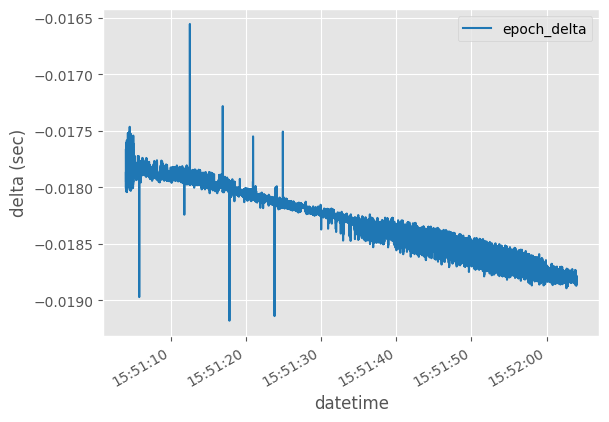

In [31]:
df.plot(x='transmit_time_dl', y='epoch_delta', color='tab:blue',
        xlabel='datetime', ylabel='delta (sec)')
plt.show()

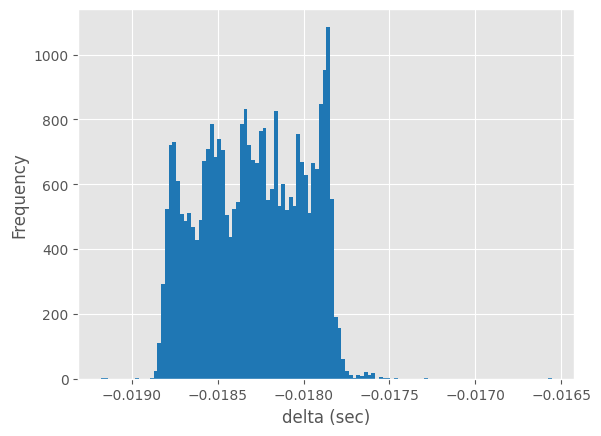

In [32]:
df['epoch_delta'].plot(kind='hist', bins=120, color='tab:blue')
plt.xlabel('delta (sec)')
plt.show()

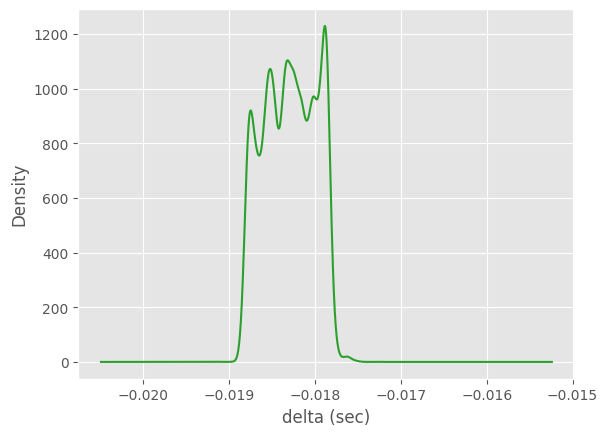

In [33]:
df['epoch_delta'].plot(kind='kde', color='tab:green')
plt.xlabel('delta (sec)')
plt.show()

-0.018293800020004667
-0.018291
-0.017861


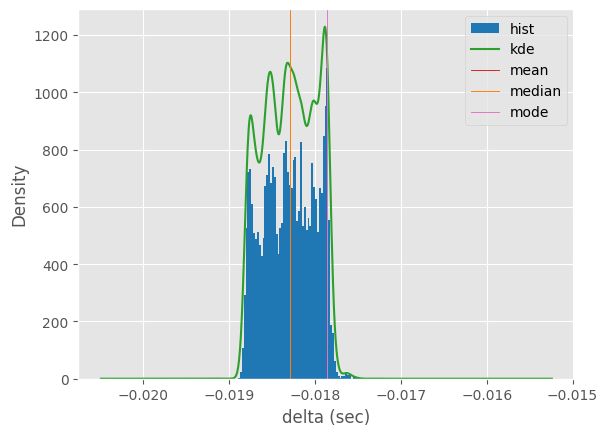

In [34]:
fig, ax = plt.subplots()
df['epoch_delta'].plot(kind='hist', bins=120, color='tab:blue', label='hist', ax=ax)
df['epoch_delta'].plot(kind='kde', color='tab:green', label='kde', ax=ax)
plt.xlabel('delta (sec)')
plt.axvline(df['epoch_delta'].mean(), color='tab:red', label='mean', linewidth=0.7)
plt.axvline(df['epoch_delta'].median(), color='tab:orange', label='median', linewidth=0.7)
plt.axvline(df['epoch_delta'].mode()[0], color='tab:pink', label='mode', linewidth=0.7)
plt.legend()
fig.show()

print(df['epoch_delta'].mean())
print(df['epoch_delta'].median())
print(df['epoch_delta'].mode()[0])

## Outliers

In [35]:
display(df)

,sequence_num,transmit_time_ul,transmit_time_epoch_ul,arrival_time_ul,arrival_time_epoch_ul,transmit_time_dl,transmit_time_epoch_dl,arrival_time_dl,arrival_time_epoch_dl,latency_ul,latency_dl,epoch_delta,datetime_delta
0,8,2022-11-29 15:51:04.041253,1.669708e+09,2022-11-29 15:51:04.023921,1.669708e+09,2022-11-29 15:51:04.023214,1.669708e+09,2022-11-29 15:51:04.041221,1.669708e+09,-0.017332,0.018007,-0.017669,-1 days +23:59:59.982331
1,9,2022-11-29 15:51:04.043246,1.669708e+09,2022-11-29 15:51:04.025720,1.669708e+09,2022-11-29 15:51:04.025200,1.669708e+09,2022-11-29 15:51:04.043404,1.669708e+09,-0.017526,0.018204,-0.017865,-1 days +23:59:59.982135
2,10,2022-11-29 15:51:04.045248,1.669708e+09,2022-11-29 15:51:04.027716,1.669708e+09,2022-11-29 15:51:04.027196,1.669708e+09,2022-11-29 15:51:04.045405,1.669708e+09,-0.017532,0.018209,-0.017871,-1 days +23:59:59.982129
3,11,2022-11-29 15:51:04.047366,1.669708e+09,2022-11-29 15:51:04.029749,1.669708e+09,2022-11-29 15:51:04.029215,1.669708e+09,2022-11-29 15:51:04.047427,1.669708e+09,-0.017617,0.018212,-0.017914,-1 days +23:59:59.982086
4,12,2022-11-29 15:51:04.049354,1.669708e+09,2022-11-29 15:51:04.031737,1.669708e+09,2022-11-29 15:51:04.031219,1.669708e+09,2022-11-29 15:51:04.049423,1.669708e+09,-0.017617,0.018204,-0.017910,-1 days +23:59:59.982090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29988,29996,2022-11-29 15:52:04.017394,1.669708e+09,2022-11-29 15:52:03.998794,1.669708e+09,2022-11-29 15:52:03.999235,1.669708e+09,2022-11-29 15:52:04.018326,1.669708e+09,-0.018600,0.019091,-0.018846,-1 days +23:59:59.981154
29989,29997,2022-11-29 15:52:04.019391,1.669708e+09,2022-11-29 15:52:04.000758,1.669708e+09,2022-11-29 15:52:04.001237,1.669708e+09,2022-11-29 15:52:04.020197,1.669708e+09,-0.018633,0.018960,-0.018797,-1 days +23:59:59.981203
29990,29998,2022-11-29 15:52:04.021395,1.669708e+09,2022-11-29 15:52:04.002793,1.669708e+09,2022-11-29 15:52:04.003235,1.669708e+09,2022-11-29 15:52:04.022332,1.669708e+09,-0.018602,0.019097,-0.018849,-1 days +23:59:59.981151
29991,29999,2022-11-29 15:52:04.023392,1.669708e+09,2022-11-29 15:52:04.004762,1.669708e+09,2022-11-29 15:52:04.005233,1.669708e+09,2022-11-29 15:52:04.024261,1.669708e+09,-0.018630,0.019028,-0.018829,-1 days +23:59:59.981171


In [36]:
df_test = delete_outliers(df.copy())
display(df_test)

-0.019302999999999994
-0.017271


,sequence_num,transmit_time_ul,transmit_time_epoch_ul,arrival_time_ul,arrival_time_epoch_ul,transmit_time_dl,transmit_time_epoch_dl,arrival_time_dl,arrival_time_epoch_dl,latency_ul,latency_dl,epoch_delta,datetime_delta
4260,4268,2022-11-29 15:51:12.561360,1.669708e+09,2022-11-29 15:51:12.546377,1.669708e+09,2022-11-29 15:51:12.543465,1.669708e+09,2022-11-29 15:51:12.561590,1.669708e+09,-0.014983,0.018125,-0.016554,-1 days +23:59:59.983446


,sequence_num,transmit_time_ul,transmit_time_epoch_ul,arrival_time_ul,arrival_time_epoch_ul,transmit_time_dl,transmit_time_epoch_dl,arrival_time_dl,arrival_time_epoch_dl,latency_ul,latency_dl,epoch_delta,datetime_delta
0,8,2022-11-29 15:51:04.041253,1.669708e+09,2022-11-29 15:51:04.023921,1.669708e+09,2022-11-29 15:51:04.023214,1.669708e+09,2022-11-29 15:51:04.041221,1.669708e+09,-0.017332,0.018007,-0.017669,-1 days +23:59:59.982331
1,9,2022-11-29 15:51:04.043246,1.669708e+09,2022-11-29 15:51:04.025720,1.669708e+09,2022-11-29 15:51:04.025200,1.669708e+09,2022-11-29 15:51:04.043404,1.669708e+09,-0.017526,0.018204,-0.017865,-1 days +23:59:59.982135
2,10,2022-11-29 15:51:04.045248,1.669708e+09,2022-11-29 15:51:04.027716,1.669708e+09,2022-11-29 15:51:04.027196,1.669708e+09,2022-11-29 15:51:04.045405,1.669708e+09,-0.017532,0.018209,-0.017871,-1 days +23:59:59.982129
3,11,2022-11-29 15:51:04.047366,1.669708e+09,2022-11-29 15:51:04.029749,1.669708e+09,2022-11-29 15:51:04.029215,1.669708e+09,2022-11-29 15:51:04.047427,1.669708e+09,-0.017617,0.018212,-0.017914,-1 days +23:59:59.982086
4,12,2022-11-29 15:51:04.049354,1.669708e+09,2022-11-29 15:51:04.031737,1.669708e+09,2022-11-29 15:51:04.031219,1.669708e+09,2022-11-29 15:51:04.049423,1.669708e+09,-0.017617,0.018204,-0.017910,-1 days +23:59:59.982090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29987,29996,2022-11-29 15:52:04.017394,1.669708e+09,2022-11-29 15:52:03.998794,1.669708e+09,2022-11-29 15:52:03.999235,1.669708e+09,2022-11-29 15:52:04.018326,1.669708e+09,-0.018600,0.019091,-0.018846,-1 days +23:59:59.981154
29988,29997,2022-11-29 15:52:04.019391,1.669708e+09,2022-11-29 15:52:04.000758,1.669708e+09,2022-11-29 15:52:04.001237,1.669708e+09,2022-11-29 15:52:04.020197,1.669708e+09,-0.018633,0.018960,-0.018797,-1 days +23:59:59.981203
29989,29998,2022-11-29 15:52:04.021395,1.669708e+09,2022-11-29 15:52:04.002793,1.669708e+09,2022-11-29 15:52:04.003235,1.669708e+09,2022-11-29 15:52:04.022332,1.669708e+09,-0.018602,0.019097,-0.018849,-1 days +23:59:59.981151
29990,29999,2022-11-29 15:52:04.023392,1.669708e+09,2022-11-29 15:52:04.004762,1.669708e+09,2022-11-29 15:52:04.005233,1.669708e+09,2022-11-29 15:52:04.024261,1.669708e+09,-0.018630,0.019028,-0.018829,-1 days +23:59:59.981171
